In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
num_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_ds = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.MNIST('./data/', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(train_loader)
batch_idx, (X, Y) = next(examples)
print(X.shape)
print(Y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [40]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.network = torch.nn.Sequential(*[
            torch.nn.Conv2d(1, 2, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(2, 4, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(4, 8, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(8, 16, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Flatten(-3, -1),
            torch.nn.Linear(16, 10)
        ])
    def forward(self, X):
        return self.network(X)
net = Network() 
print(X.shape, net(X).shape)

torch.Size([64, 1, 28, 28]) torch.Size([64, 10])


In [41]:
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=3e-4)


In [42]:
def calc_ds_stats(net, loader):
    losses = []
    accs = []
    for batch_idx, (X_batch, Y_batch) in enumerate(loader):
        Y_batch_pred = net(X_batch)
        loss = loss_function(Y_batch_pred, Y_batch)
        losses.append(loss.item())
        Y_batch_pred_idx = Y_batch_pred.argmax(dim=-1)
        acc = (Y_batch_pred_idx==Y_batch).sum().item()/len(Y_batch)
        accs.append(acc)
    return np.average(losses), np.average(accs)

In [43]:
calc_ds_stats(net, test_loader)

(2.3083539724349977, 0.1202)

In [44]:
losses = []
pgrad = None
angs = []
for epoch_idx in range(num_epochs):
#     for batch_idx, (X_batch, Y_batch) in enumerate(train_loader):
    X_batch, Y_batch = X, Y
    
    
    
    
    Y_batch_pred = net(X_batch)
    loss = loss_function(Y_batch_pred, Y_batch)
    opt.zero_grad()
    loss.backward()

    grad = get_grad(net)
    opt.step()

    if pgrad is not None:
        cs = torch.cosine_similarity(pgrad, grad, dim=0)
        ang = torch.arccos(cs)
        angs.append(ang)

    pgrad = grad

    losses.append(loss.item())
        
#     plt.plot(losses);plt.show() 
    print(calc_ds_stats(net, test_loader))


(2.308080792427063, 0.1222)
(2.307817077636719, 0.1234)
(2.3075570106506347, 0.12610000000000002)
(2.307305645942688, 0.1279)
(2.30705840587616, 0.13140000000000002)
(2.3068111896514893, 0.13509999999999997)
(2.306566095352173, 0.1378)
(2.306323599815369, 0.143)
(2.3060813903808595, 0.1459)
(2.305845260620117, 0.14919999999999997)


In [45]:
calc_ds_stats(net, test_loader)

(2.3058449983596803, 0.14919999999999997)

(-10.0, 10.0)

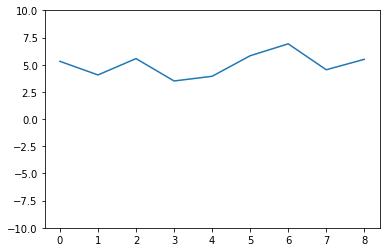

In [53]:
plt.plot([a.item()*180./np.pi for a in angs])
plt.ylim(-10,10)

# These results show that
### If taking steps on entire training set (not stochastic batches), then the direction of the steps are relatively constant (near 0 degrees)

In [28]:
def get_grad(net):
    full_grad = None
    for p in net.parameters():
        g = p.grad
        if g is None:
            g = torch.zeros_like(p)
        g = g.detach().clone().flatten()
        if full_grad is None:
            full_grad = g
        else:
            full_grad = torch.cat([full_grad, g])
    return full_grad
        
